Yfinance- to download stock data
pandas-data storage
matplotlib- to plot and visualize our data and strategy returns 
numpy- manipulating data

In [50]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Use the yf.download function to download data on the apple stock, ranging from April 1st 2017 to April 30th 2019

In [51]:
data = yf.download('AAPL', start="2017-04-01", end="2019-04-30")

[*********************100%***********************]  1 of 1 completed


Use the data.head() function to visualize the first 5 rows of your dataframe. Helpful to see the coloumns and rows you are working with and if you downloaded the right information. 

In [52]:
data.head()

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-04-03  35.927502  36.029999  35.762501  35.924999  34.120541   79942800
2017-04-04  35.812500  36.222500  35.792500  36.192501  34.374607   79565600
2017-04-05  36.055000  36.365002  35.952499  36.005001  34.196522  110871600
2017-04-06  36.072498  36.130001  35.862499  35.915001  34.111042   84596000
2017-04-07  35.932499  36.044998  35.817501  35.834999  34.035061   66688800

Using the matplotlib .style.use function choose ggplot. It is easy to use and decides certain features of plots for any plot you would make in the same script unless overriden. 

In [53]:
plt.style.use('ggplot')

use .figure(figsize=(width,height) to set width and height of the plot)
Input the data, by specifying what coloumn you want to plot. In this case "Close".
Finally, to show legends, you can just call the legend function and show function to display the plot

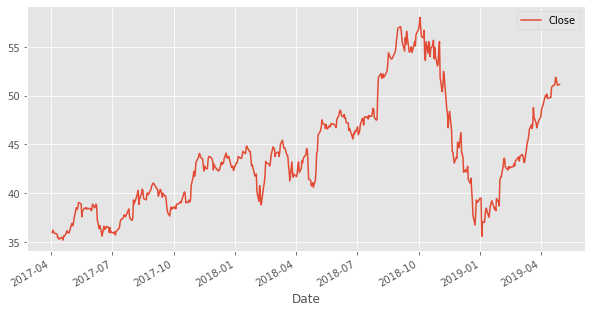

In [54]:
plt.figure(figsize=(10,5))
data['Close'].plot(figsize=(10,5))
plt.legend()
plt.show()

To calculate the MACD, you need to get the difference of 2 exponential moving average series. To calculate those we use the .ewm function and take the mean.
The period can be specified in span as shown below.

In [55]:
data['12d_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
data['26d_EMA'] = data.Close.ewm(span=26, adjust=False).mean()

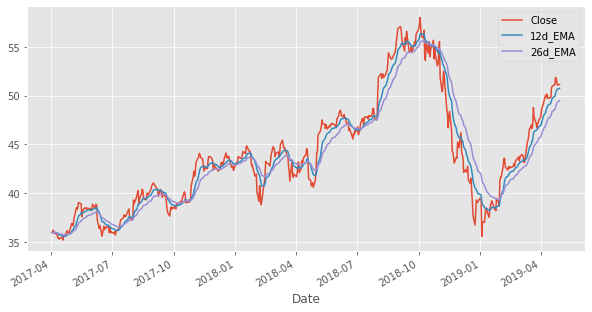

In [56]:
data[['Close','12d_EMA','26d_EMA']].plot(figsize=(10,5))
plt.show()

Taking the difference of 12 day and 26 day exponential moving average to get the MACD of the series. 

In [ ]:
data['macd'] = data['12d_EMA']- data['26d_EMA'] 

As part of the strategy a signal is needed, so use a 9 day exponential moving average from the MACD just calculated. 

In [ ]:
data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()

In [ ]:
data[['macd','macdsignal']].plot(figsize=(10,5))
plt.show()

To finally get the signal, whenever MACD value goes higher than the 9 day moving average, put a 1, otherwise a -1. Whenever the value is 1, we should buy and whenever it is -1, we should sell.

In [ ]:
data['trading_signal'] = np.where(data['macd'] > data['macdsignal'], 1, -1)

To calculate returns, use the pct_change function on the close coloumn which gives you the percent chnage in value from the rows immediately before in the dataframe

In [ ]:
data['returns'] = data.Close.pct_change()

To get the strategy returns, just use the returns* the signal, where we would have bought/sold.
To get the cummulative returns, use the cumprod function to see progress over time.  

In [ ]:
data['strategy_returns'] = data.returns * data.trading_signal.shift(1)
cumulative_strategy_returns = (data.strategy_returns + 1).cumprod()

In [ ]:
cumulative_strategy_returns.plot(figsize=(10,5))
plt.legend()
plt.show()

To evaluate the strategy and how well it worked, we can calculate three measures, amnnual returns, annual volatility and sharpe ratio. The first step is to get the number of trading days.

In [ ]:
days = len(cumulative_strategy_returns)

Finally, we calcualte the annual growth rate using the formula CAGR = [(Final value of investment /Initial value of investment)^(1/number of years)] - 1

In [ ]:
annual_returns = (cumulative_strategy_returns.iloc[-1]**(252/days) - 1)*100

print('The CAGR is %.2f%%' % annual_returns)

Next, we calculate the annual volatility which can be done using the formula Annualised Volatility = square root (trading days) * square root (variance). This measure tells us the variation of the stock price in the time period we are testing.

In [ ]:
annual_volatility = data.strategy_returns.std() * np.sqrt(252) * 100

'The annualised volatility is %.2f%%' % annual_volatility

Laslty, we calculate the sharpe ratio. This measures the performance of an investment compared to a risk free asset by adjusting for risk. We can calulate this using Sharpe ratio = [annualized return of investment - annualized risk free rate] / standard deviation of annualized return of investment. 

We will base our caculations on an assumed 6% of risk free rate. 

In [ ]:
risk_free_rate = 0.06
daily_risk_free_return = risk_free_rate/252

excess_daily_returns = data.strategy_returns - daily_risk_free_return

# Calculate the sharpe ratio using the given formula
sharpe_ratio = (excess_daily_returns.mean() /
                excess_daily_returns.std()) * np.sqrt(252)

'The Sharpe ratio is %.2f' % sharpe_ratio